In [5]:
#from data import CocoDatasetManager
from collections import Counter
from backbone import ClassificationRCNN
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import UnidentifiedImageError
import matplotlib.pyplot as plt


In [7]:
# Check if CUDA (GPU support) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Loading the dataset

In [9]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #imagenet transformation
])

# Load the dataset
full_dataset = datasets.ImageFolder(root='/home/amanandhar/Transferlearning/RCNN-classification/src/data/train', transform=transform)

# Split the dataset into train and test sets
train_size = int(0.8 * len(full_dataset))  # 80% of the dataset
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [10]:
print("Number of training Images: ", len(train_dataset))
print("Number of test_loader: ", len(test_dataset))

Number of training Images:  7499
Number of test_loader:  1875


## Loading the model

In [11]:

model = ClassificationRCNN(num_classes=79)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/home/amanandhar/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/amanandhar/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
model = model.to(device)  # Move the model to GPU

In [13]:
model

ClassificationRCNN(
  (resnet_backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        

## Training the model

In [14]:
num_epochs = 100
loss_graph = []
accuracy_graph = []

print(f"Starting training for {num_epochs} epochs.")

for epoch in range(num_epochs):
    model.train() 
    print(f"Epoch {epoch+1} started.")
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        try:
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 10 == 0: 
                loss_value = loss.item()
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch {i}, Loss: {loss_value:.4f}")

        except Exception as e:
            print(f"An error occurred: {e}")
    loss_graph.append(loss_value)

    # Validation phase
    model.eval()  
    total_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(test_loader)
    accuracy = (correct_predictions / total_predictions) * 100
    accuracy_graph.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}] completed, Training Loss: {loss.item():.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')


Starting training for 100 epochs.
Epoch 1 started.
Epoch [1/100], Batch 0, Loss: 4.3683
Epoch [1/100], Batch 10, Loss: 3.5579
Epoch [1/100], Batch 20, Loss: 3.4373
Epoch [1/100], Batch 30, Loss: 3.1836
Epoch [1/100], Batch 40, Loss: 3.4639
Epoch [1/100], Batch 50, Loss: 3.1442
Epoch [1/100], Batch 60, Loss: 3.7459
Epoch [1/100], Batch 70, Loss: 3.1658
Epoch [1/100], Batch 80, Loss: 3.4746
Epoch [1/100], Batch 90, Loss: 2.4191
Epoch [1/100], Batch 100, Loss: 3.3117
Epoch [1/100], Batch 110, Loss: 3.3767
Epoch [1/100], Batch 120, Loss: 2.9725
Epoch [1/100], Batch 130, Loss: 2.9363
Epoch [1/100], Batch 140, Loss: 3.1547
Epoch [1/100], Batch 150, Loss: 2.8536
Epoch [1/100], Batch 160, Loss: 3.4095
Epoch [1/100], Batch 170, Loss: 2.3805
Epoch [1/100], Batch 180, Loss: 2.5312
Epoch [1/100], Batch 190, Loss: 3.1336
Epoch [1/100], Batch 200, Loss: 3.2136
Epoch [1/100], Batch 210, Loss: 3.1661
Epoch [1/100], Batch 220, Loss: 3.1378
Epoch [1/100], Batch 230, Loss: 3.2336
Epoch [1/100] completed,

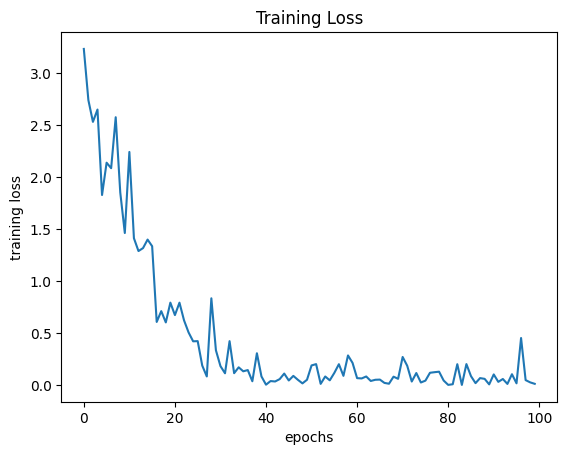

In [15]:
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.plot(loss_graph)

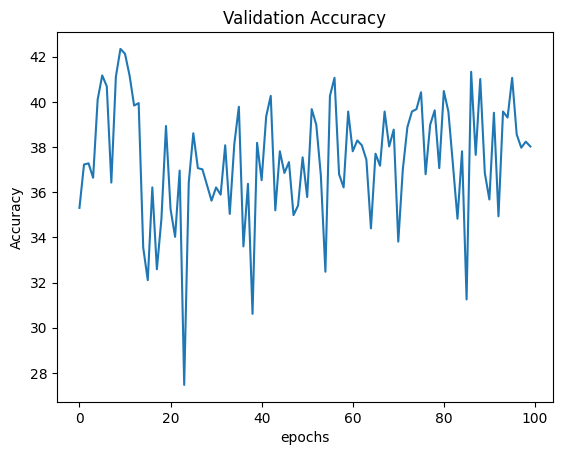

In [16]:
plt.title("Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.plot(accuracy_graph)